In [3]:
!pip install torch


   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 1.0/204.1 MB 3.3 MB/s eta 0:01:01
   ---------------------------------------- 2.4/204.1 MB 4.2 MB/s eta 0:00:49
    --------------------------------------- 3.4/204.1 MB 4.3 MB/s eta 0:00:47
    --------------------------------------- 4.5/204.1 MB 4.6 MB/s eta 0:00:44
   - -------------------------------------- 6.6/204.1 MB 5.4 MB/s eta 0:00:37
   - -------------------------------------- 8.7/204.1 MB 6.2 MB/s eta 0:00:32
   -- ------------------------------------- 10.7/204.1 MB 6.6 MB/s eta 0:00:30
   -- ------------------------------------- 13.6/204.1 MB 7.4 MB/s eta 0:00:26
   --- ------------------------------------ 16.3/204.1 MB 7.9 MB/s eta 0:00:24
   --- ------------------------------------ 19.4/204.1 MB 8.6 MB/s eta 0:00:22
   ---- ----------------------------------- 22.0/204.1 MB 8.9 MB/s eta 0:0


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


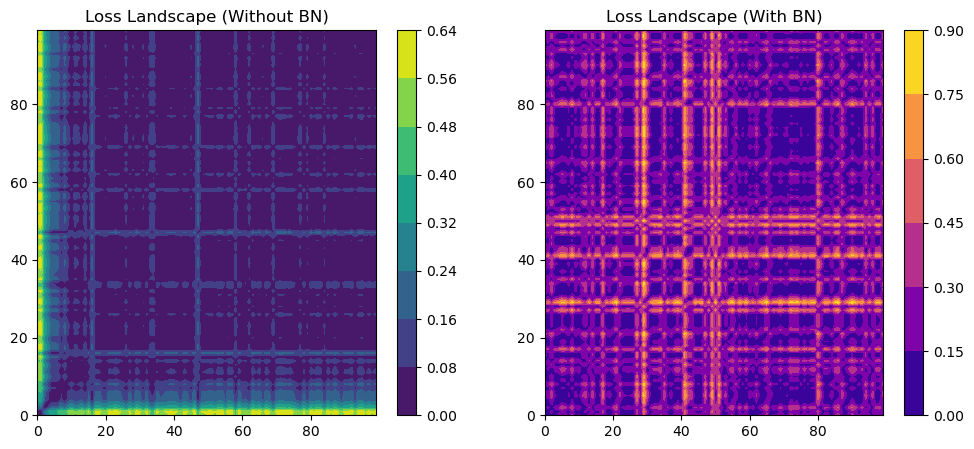

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Generate synthetic dataset
def generate_data(n_samples=500):
    X = np.random.rand(n_samples, 2) * 2 - 1  # Random points in [-1, 1]
    y = (X[:, 0]**2 + X[:, 1]**2 < 0.5).astype(np.float32)  # Circle decision boundary
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Define neural networks
class NetWithoutBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

class NetWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Training function
def train_model(model, dataloader, epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_history = []
    for epoch in range(epochs):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        loss_history.append(loss.item())
    return np.array(loss_history)

# Prepare data
X, y = generate_data()
dataloader = DataLoader(TensorDataset(X, y), batch_size=32, shuffle=True)

# Train both models
model_no_bn = NetWithoutBN()
model_bn = NetWithBN()
loss_no_bn = train_model(model_no_bn, dataloader)
loss_bn = train_model(model_bn, dataloader)

# Contour plot setup
def plot_loss_landscape(loss_no_bn, loss_bn):
    epochs = np.arange(len(loss_no_bn))
    X, Y = np.meshgrid(epochs, epochs)
    Z_no_bn = np.abs(loss_no_bn[X] - loss_no_bn[Y])
    Z_bn = np.abs(loss_bn[X] - loss_bn[Y])
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    c1 = ax[0].contourf(X, Y, Z_no_bn, cmap='viridis')
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title('Loss Landscape (Without BN)')
    
    c2 = ax[1].contourf(X, Y, Z_bn, cmap='plasma')
    fig.colorbar(c2, ax=ax[1])
    ax[1].set_title('Loss Landscape (With BN)')
    
    plt.show()

plot_loss_landscape(loss_no_bn, loss_bn)


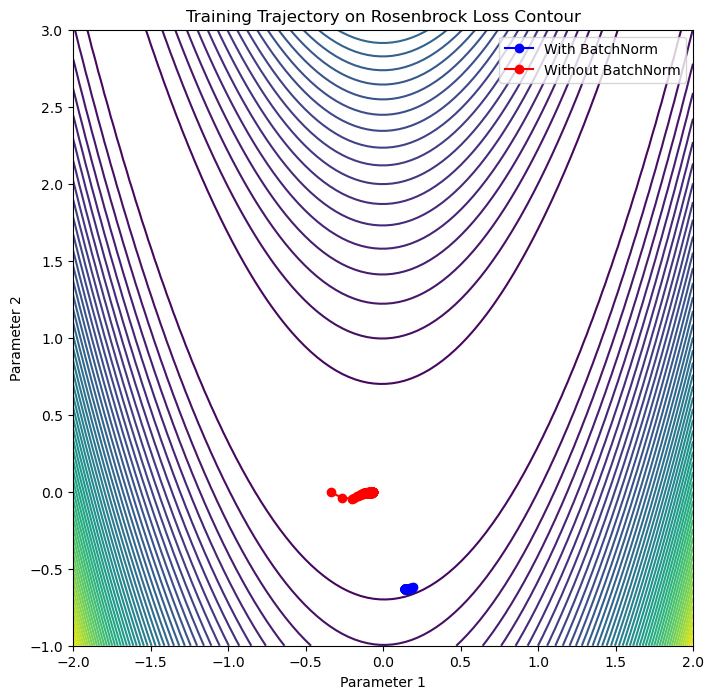

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class Net(nn.Module):
    def __init__(self, batch_norm=False):  # Fixed __init__
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.bn1 = nn.BatchNorm1d(2) if batch_norm else nn.Identity()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        return x

# Rosenbrock function
class RosenbrockLoss(nn.Module):
    def forward(self, x, y=None):
        return torch.mean(100 * (x[:, 1] - x[:, 0]**2)**2 + (1 - x[:, 0])**2)  # Fixed exponentiation

def train_with_trajectory(model, criterion, lr=0.001, epochs=100):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    trajectory = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        dummy_input = torch.randn(100, 2)
        output = model(dummy_input)
        loss = criterion(output)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            params = np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters()])  # Fixed GPU handling
            trajectory.append(params)
    return np.array(trajectory)

# Instantiate models and loss function
model_bn = Net(batch_norm=True)
model_no_bn = Net(batch_norm=False)
criterion = RosenbrockLoss()

# Train models and get trajectories
traj_bn = train_with_trajectory(model_bn, criterion)
traj_no_bn = train_with_trajectory(model_no_bn, criterion)

# Generate loss landscape
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X_grid, Y_grid = np.meshgrid(x, y)
Z = 100 * (Y_grid - X_grid**2)**2 + (1 - X_grid)**2  # Fixed exponentiation

# Plot contour and trajectories
plt.figure(figsize=(8, 8))
plt.contour(X_grid, Y_grid, Z, levels=50, cmap='viridis')
plt.plot(traj_bn[:, 0], traj_bn[:, 1], 'o-', label='With BatchNorm', color='blue')
plt.plot(traj_no_bn[:, 0], traj_no_bn[:, 1], 'o-', label='Without BatchNorm', color='red')
plt.title('Training Trajectory on Rosenbrock Loss Contour')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.legend()
plt.show()
